##  1. Imports

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


##  2. Load and Prepare Data

In [253]:
df = pd.read_csv('../../Data/final/sales_forecast_data.csv')
df['SalesDate'] = pd.to_datetime(df['SalesDate'])
df = df.sort_values(by=['StoreID', 'ItemID', 'SalesDate'])


##  3. Feature Engineering

In [254]:
df['DayOfWeek'] = df['SalesDate'].dt.dayofweek
df['DayOfMonth'] = df['SalesDate'].dt.day
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)


##  4. Define Target and Features

In [255]:
target_col = 'SalesQuantity'
feature_cols = ['Lag_1', 'Lag_7', 'RollingAvg_7', 'Month', 'DayOfWeek', 
                'DayOfMonth', 'IsWeekend']

X = df[feature_cols]
y = df[target_col]


##  5. Train-Test Split

In [256]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

##  6. Scale Features

In [257]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


##  7. Train XGBoost Model

In [258]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)
model = grid_search.best_estimator_


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


##  8. Predictions & Evaluation

In [259]:
y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error: 0.9795
Root Mean Square Error: 1.4115
R² Score: 0.2189


### Explanation of metrics:
**SalesQuantity Statistics Recap**
- Count: 70,830 rows
- Mean: 12.06
- Std: 10.63
- Min: 3.00
- 25%: 6.00
- 50% (Median): 11.00
- 75%: 12.00
- Max: 48.00

### 1. Mean Absolute Error (MAE: 0.9795)
- **Meaning**: Predictions are off by ~0.98 units of SalesQuantity on average
- **Implication**: Good performance on typical days (6-12 units) but may miss larger spikes (near 48)

### 2. Root Mean Square Error (RMSE: 1.4115)
- **Meaning**: Higher than MAE, indicating some larger prediction errors
- **Implication**: Model struggles with outliers/high-sales events (30-48 range)

### 3. R² Score (0.2189)
- **Meaning**: Model explains only ~21.89% of sales variance
- **Implication**: Missing critical explanatory variables for high-sales days

**Strengths & Limitations**
- Model performs well for average conditions with ~8% error rate
- Struggles with extreme values, which inflate RMSE due to squared error weighting
- Model likely underpredicts high-sales events in the 30-48 range

##  9. Plot Predictions vs Actual (First 100 Days)

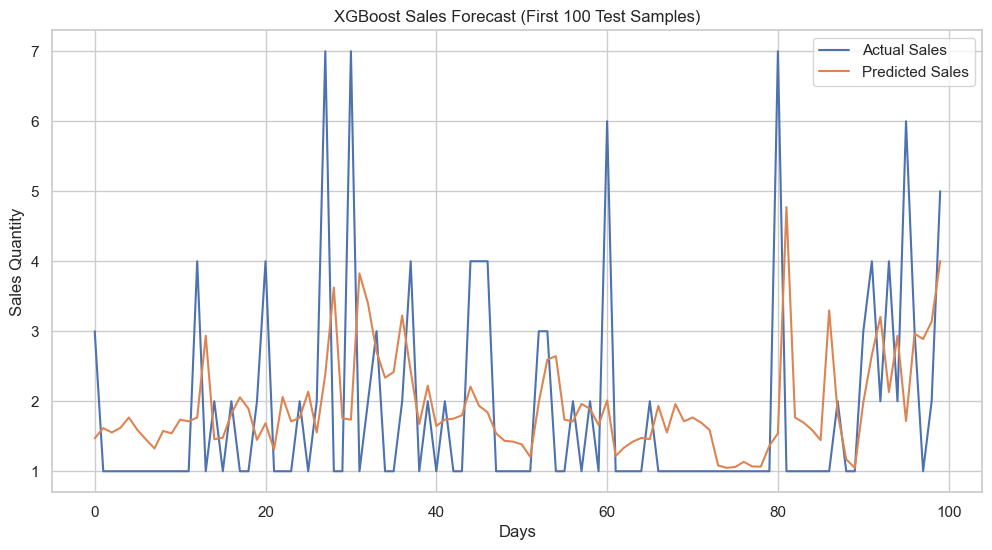

In [260]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100].values, label='Actual Sales')
plt.plot(y_pred[:100], label='Predicted Sales')
plt.title("XGBoost Sales Forecast (First 100 Test Samples)")
plt.xlabel("Days")
plt.ylabel("Sales Quantity")
plt.legend()
plt.savefig('../../artifacts/plots/sales_forecast_first100_plot.png')
plt.show()


##  10. Forecast Next 7 Days

In [261]:
last_row = df.iloc[-1:].copy()

future_preds = []
future_dates = []
current_row = last_row.copy()

for i in range(7):
    X_pred = current_row[feature_cols].values.reshape(1, -1)
    next_pred = model.predict(X_pred)[0]
    future_preds.append(next_pred)

    new_row = current_row.copy()
    
    if 'Lag_1' in new_row.columns:
        new_row['Lag_1'] = next_pred
    if 'Lag_7' in new_row.columns:
        new_row['Lag_7'] = current_row['Lag_1'].values[0] if 'Lag_1' in current_row else next_pred
    if 'RollingAvg_7' in new_row.columns:
        new_row['RollingAvg_7'] = current_row['RollingAvg_7'].values[0] if 'RollingAvg_7' in current_row else next_pred

    new_row['SalesDate'] = pd.to_datetime(new_row['SalesDate']) + pd.Timedelta(days=1)
    new_row['DayOfMonth'] = new_row['SalesDate'].dt.day
    new_row['DayOfWeek'] = new_row['SalesDate'].dt.dayofweek
    new_row['Quarter'] = new_row['SalesDate'].dt.quarter
    new_row['IsWeekend'] = 1 if new_row['DayOfWeek'].values[0] >= 5 else 0

    future_dates.append(new_row['SalesDate'].values[0])
    current_row = new_row.copy()

# Convert numpy.datetime64 to pandas Timestamp
future_dates = [pd.Timestamp(d) for d in future_dates]

# Create DataFrame for the forecast
forecast_df = pd.DataFrame({
    'SalesDate': future_dates,
    'Predicted_Value': future_preds,
    'DayOfMonth': [d.day for d in future_dates],
    'DayOfWeek': [d.dayofweek for d in future_dates],
    'Quarter': [d.quarter for d in future_dates],
    'IsWeekend': [1 if d.dayofweek >= 5 else 0 for d in future_dates]
})

# Export to CSV
forecast_df.to_csv('../../artifacts/predictions/sales_forecast_pred.csv', index=False)

print("Forecast for next 7 days:", future_preds)
print("Forecast saved to '../../artifacts/predictions/sales_forecast_pred.csv'")


Forecast for next 7 days: [np.float32(0.7684015), np.float32(0.8346346), np.float32(0.7659106), np.float32(0.9120942), np.float32(0.98761994), np.float32(0.5536916), np.float32(0.836572)]
Forecast saved to '../../artifacts/predictions/sales_forecast_pred.csv'


##  Sales Forecast: Actual vs Predicted + 7-Day Projection"

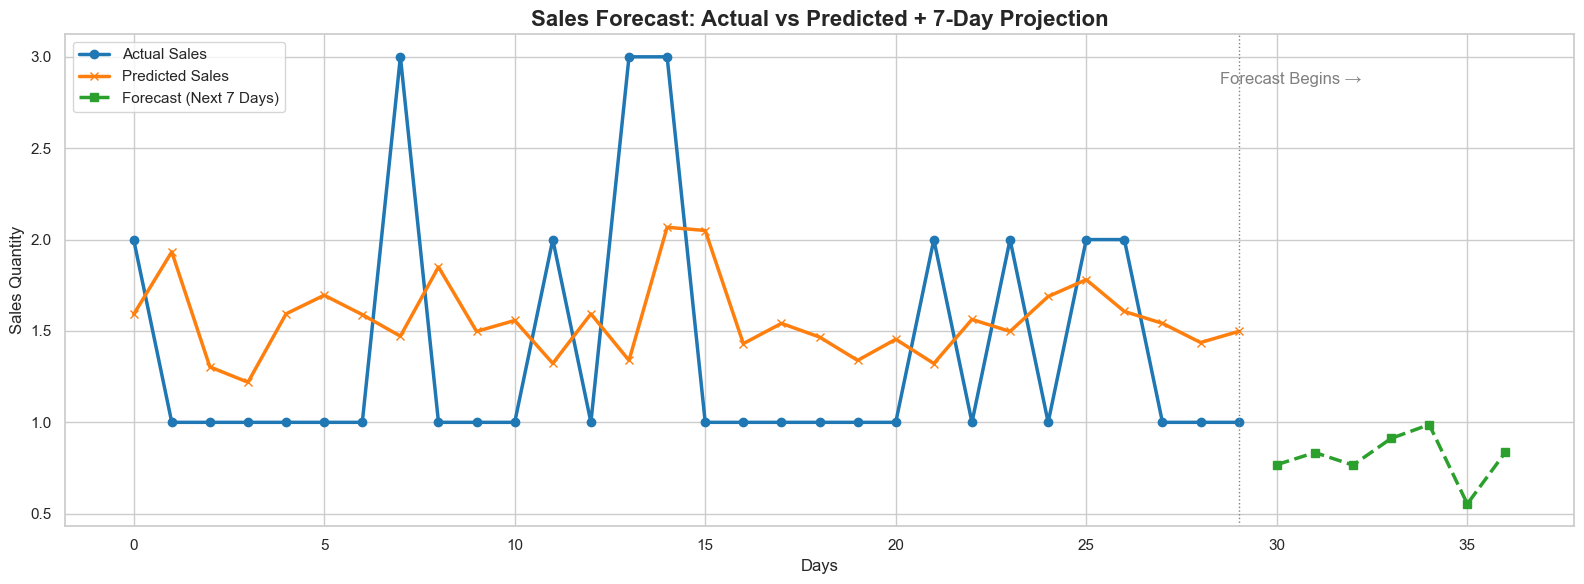

In [262]:
# Use seaborn style for cleaner visuals
sns.set(style="whitegrid")

# Prepare values
y_test_plot = y_test[-30:].values
y_pred_plot = y_pred[-30:]
forecasted_values = future_preds
x_actual = np.arange(len(y_test_plot))
x_forecast = np.arange(len(y_test_plot), len(y_test_plot) + len(forecasted_values))

# Plot
plt.figure(figsize=(16, 6))
plt.plot(x_actual, y_test_plot, label='Actual Sales', linewidth=2.5, color='#1f77b4', marker='o')
plt.plot(x_actual, y_pred_plot, label='Predicted Sales', linewidth=2.5, color='#ff7f0e', marker='x')
plt.plot(x_forecast, forecasted_values, label='Forecast (Next 7 Days)', linewidth=2.5, color='#2ca02c', linestyle='--', marker='s')

# Vertical line to mark prediction/forecast boundary
plt.axvline(x=len(y_test_plot)-1, color='gray', linestyle=':', linewidth=1)
plt.text(len(y_test_plot)-1.5, max(max(y_test_plot), max(forecasted_values)) * 0.95, 'Forecast Begins →', color='gray')

# Labels & Legend
plt.title("Sales Forecast: Actual vs Predicted + 7-Day Projection", fontsize=16, weight='bold')
plt.xlabel("Days", fontsize=12)
plt.ylabel("Sales Quantity", fontsize=12)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('../../artifacts/plots/sales_forecast_with_7_day_projection_plot.png')
plt.show()



##  11. Save Model

In [263]:
import pickle

# Save the model to a .pkl file using pickle
with open('../../artifacts/models/sales_forecast_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved to 'sales_forecast_model.pkl'")


Model saved to 'sales_forecast_model.pkl'
